# Simple Convolutional Neural
The first task will be to train a simple convolutional neural network using these images (a very simple 3-5 convolutional network will suffice) and test the accuracy of the model using the validation set.

> Import libraries

In [1]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

from constants import *

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Running on : ',device)

Running on :  cuda


>> Generate Dataloaders for train, validation and test data.


In [3]:
validation_split = 0.2
visualize_YN = True

In [4]:
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
# Normalize
norm = torchvision.transforms.Normalize(mean=DATASETMEAN,std=DATASETSD)
transform_lst = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),norm,torchvision.transforms.Resize((28, 28))])

# Read Train dataset
train_dataset = torchvision.datasets.ImageFolder('./training', transform=transform_lst)

# Randomly split train dataset to train and validation with ratio 1:0.2
all_point_idx = list(range(len(train_dataset)))
print('Total data points in train:',len(all_point_idx))
np.random.shuffle(all_point_idx)        # Shuffle indices
slice_idx = int(np.floor(validation_split * len(train_dataset)))     # index to slice at
print('Slice Index= ',slice_idx)
train_idx = all_point_idx[slice_idx:] 
print('Data points in train after split:',len(train_idx))
train_sampler = SubsetRandomSampler(train_idx)


valid_dataset = train_dataset
valid_idx = all_point_idx[:slice_idx]
print('Data points in validation set:',len(valid_idx))
valid_sampler = SubsetRandomSampler(valid_idx)

# Generate Python iterable over dataset to train and test
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, sampler=valid_sampler)

test_dataset = torchvision.datasets.ImageFolder('./validation', transform=transform_lst)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=16,shuffle = True, drop_last=True)
print('Test dataset size: ',(len(train_dataset)))

Total data points in train: 1097
Slice Index=  219
Data points in train after split: 878
Data points in validation set: 219
Test dataset size:  1097


In [5]:
print('chkpoint1')
train_loader

chkpoint1


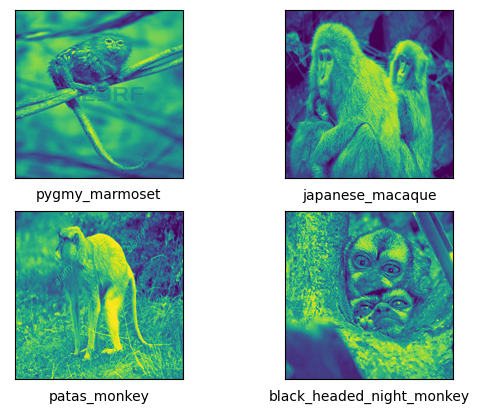

In [6]:
if visualize_YN:
    # Visualize a loaded sampler
    data_small = torch.utils.data.DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=1, pin_memory=True)
    data_iter = iter(data_small)
    X, classes_ = data_iter.next()
    X = X.numpy()
    fig, axes = plt.subplots(2, 2)
    for i, ax in enumerate(axes.flat):
        label = str(classes_[i])
        xlabel = label_dictionary[label[7]]
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X[i, 0, :, :], interpolation='spline16')
    plt.show()
    

>> Method to evaluate model 

In [7]:
def get_score(loader, model)->list:
    ''' Returns score evaluated for data in 'loader' using 'model' '''
    # data_iter = iter(loader)
    # X, classes_ = data_iter.next()
    # X = X.numpy()
    # fig, axes = plt.subplots(2, 2)
    # for i, ax in enumerate(axes.flat):
    #     label = str(classes_[i])
    #     xlabel = label
    #     ax.set_xlabel(xlabel)
    #     ax.set_xticks([])
    #     ax.set_yticks([])
    #     ax.imshow(X[i, 0, :, :], interpolation='spline16')
    # plt.show()
    score = []
    model.eval()
    count_true = 0
    total_ = 0 
    #print(loader)   
    with torch.no_grad():
        for image, label in loader:
            #print(' inside for x, y in loader')
            image = image.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            # Predict
            _, y_hat = (model(image)).max(1)
            # print(label)
            # print(y_hat)
            count_true += (y_hat == label).sum()
            total_ += y_hat.size(0)
        s = float(count_true) / total_
        score.append(s)
        print('Correct prediction for %d / %d samples. Accuracy = (%.2f)' % (count_true, total_, 100 * s))
        return score


>> Train method for any model

In [8]:
def train(model, optimizer, epochs=1):
    #print(model)
    validation_score = []
    lst_loss = []
    # print('a')
    model = model.to(device=device)
    #print('b')
    for i in range(epochs):
        #print(i)
        for batch, (img, lbl) in enumerate(train_loader):
            # print(batch)
            # print(img.shape)
            # print(lbl.shape)
            model.train()
            img = img.to(device=device, dtype=torch.float32)
            lbl = lbl.to(device=device, dtype=torch.long)
            # print(img.shape)
            #print(lbl)
            scores = model(img)
            # Computes the cross entropy loss between input and target.
            loss = F.cross_entropy(scores, lbl)
            # Optimizer
            optimizer.zero_grad()
            # Compute the gradient of current tensor w.r.t. graph leaves
            loss.backward()
            # Step
            
            optimizer.step()
            # Print result every 50th step
            if batch % 50 == 0:
                # Print Loss
                print('Epoch %d, Loss = %.4f' % (batch, loss.item()))
                # Evaluate accuracy and print
                validation_score.append(get_score(valid_loader, model))
                lst_loss.append(loss.item())
    best_val = []
    for a in validation_score:
        best_val.append(a[np.argmax(a)])
    return best_val,lst_loss,model


# Define model

In [9]:
from utils import *

In [10]:
filter = 3

model = nn.Sequential(#                                               Shape
    # (Conv->BatchNorm->Relu) *2                                 1 ---->  32
    nn.Conv2d(3, 32, 3, 1),  nn.ReLU(),
    #  2x2 Max-pool
    nn.MaxPool2d((2, 2)),
    # (Conv->BatchNorm->Relu) *2                                 32 ---->  64 
    nn.Conv2d(32, 64, filter, padding=1),    nn.BatchNorm2d(64),    nn.ReLU(),
    nn.Conv2d(64, 128, filter, padding=1),    nn.BatchNorm2d(128),    nn.ReLU(),
    #  2x2 Max-pool
    nn.MaxPool2d((2, 2)),
    Flatten(),
    # FC
    #nn.Dropout(0.2, inplace=True),  ## Drop-out
    # nn.Linear(128 * 3 * 3, 128),
    # nn.ReLU(),
    nn.Linear(4608, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
)

# # Debug Input / output dimensions
# def forward(x):
#     try:
#         for layer in model:
#             print(layer, x.size())
#             x = layer(x)
#         return x
#     except Exception as ex:
#         print(layer,'\n',ex)
# x = torch.randn(32, 3, 28, 28)
# forward(x)


In [11]:
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Flatten()
  (11): Linear(in_features=4608, out_features=32, bias=True)
  (12): ReLU()
  (13): Linear(in_features=32, out_features=10, bias=True)
)

In [12]:
# # Define optimizers to evaluate with:
optimizers = [optim.SGD(model.parameters(), lr=0.00215),
              optim.Adagrad(model.parameters(), lr=0.0023, lr_decay=0.75),
              optim.Adam(model.parameters(), lr=0.0015)]

# Define optimizers to evaluate with:
# optimizers = [optim.Adam(model.parameters(), lr=0.003)]


In [13]:
#model = neural_net
best_val,lst_loss,best_model = train(model, optimizers[0], epochs=50)


Epoch 0, Loss = 2.2481
Correct prediction for 21 / 219 samples. Accuracy = (9.59)
Epoch 50, Loss = 2.2773
Correct prediction for 58 / 219 samples. Accuracy = (26.48)
Epoch 0, Loss = 2.0516
Correct prediction for 32 / 219 samples. Accuracy = (14.61)
Epoch 50, Loss = 1.9738
Correct prediction for 76 / 219 samples. Accuracy = (34.70)
Epoch 0, Loss = 2.0657
Correct prediction for 67 / 219 samples. Accuracy = (30.59)
Epoch 50, Loss = 1.9597
Correct prediction for 89 / 219 samples. Accuracy = (40.64)
Epoch 0, Loss = 1.6164
Correct prediction for 75 / 219 samples. Accuracy = (34.25)
Epoch 50, Loss = 1.6333
Correct prediction for 94 / 219 samples. Accuracy = (42.92)
Epoch 0, Loss = 1.3157
Correct prediction for 85 / 219 samples. Accuracy = (38.81)
Epoch 50, Loss = 1.6637
Correct prediction for 92 / 219 samples. Accuracy = (42.01)
Epoch 0, Loss = 1.4014
Correct prediction for 97 / 219 samples. Accuracy = (44.29)
Epoch 50, Loss = 1.5031
Correct prediction for 105 / 219 samples. Accuracy = (47.95

In [16]:
best_val[np.argmax(best_val)]

0.6484018264840182

In [17]:
test_acc_sgd = get_score(test_loader, best_model)

Correct prediction for 171 / 272 samples. Accuracy = (62.87)


## Plot Results

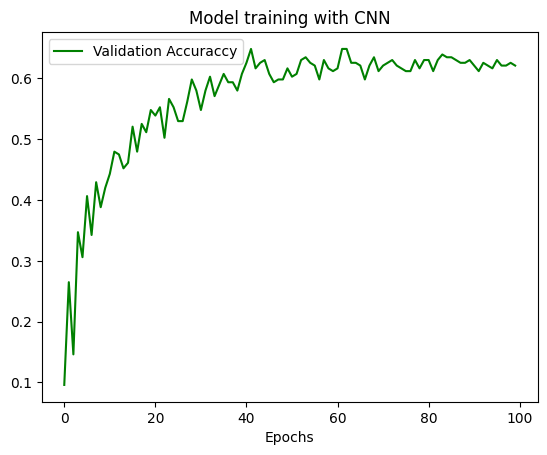

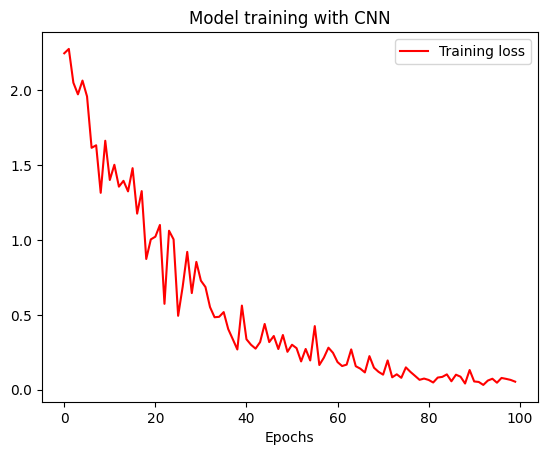

In [19]:
plt.plot(range(len(best_val)), best_val, 'g', label='Validation Accuraccy')
plt.title('Model training with CNN')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.plot(range(len(lst_loss)), lst_loss, 'r', label='Training loss')
plt.title('Model training with CNN')
plt.xlabel('Epochs')
plt.legend()
plt.show()